In [1]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
import numpy as np
from math import pi,sqrt

def wrap(job,job_id,task_id):
    def singlerun(kaf,L,run,paform):
        rm = 0.005
        f=1        
        gamma=0.577
        N = 100
        import numpy as np
        factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        voxelr=rm
        D = 1
        ka=kaf*D
        #print('ka',ka,'D',D)
        if paform=='new':
            f=1.0209
            PP=1./(1+math.sqrt(3)*(math.log(1./3)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
            ka = PP*D/factor
        voxelr = rm*f
        tm =(2*voxelr)**2/(4*D)
        H = 3*voxelr*2
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)        
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)
        size=tuple(w.calculate_shape(Real3(H,L,L),voxelr))
        w.add_structure(Species('X'),PlanarSurface(ori,unit0,unit1))
        Nmv=size[1]*size[2]        
        Area=Nmv*(2*voxelr)**2
        #print('A',L*L,Area)
        C=float(N)/Area
        with species_attributes():
            A |  {'D': str(0), 'radius':str(voxelr),'location':'X'}
            B |  {'D': str(D), 'radius':str(voxelr),'location':'X'}

        with reaction_rules():#for spa and egfrd
            A + B > B | ka

        m2 = get_model()
        w.bind_to(m2)

        na=1
        w.add_molecules(Species('A'), na)
        w.add_molecules(Species('B'), N)
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        simt=0
        while na==1:
            sim.step()
            na = w.num_particles_exact(Species('A'))
            simt=sim.t()
        return simt,C
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

kaf=0.01
simrun=10#000#1000#3000
#Ls=[7,3,1,0.4,0.3]
Ls = [1]

print(kaf)
for L in Ls:
    print('L',L)
    rxt=[]
    conc=[]
    for paform in ['ori','new']:
        print(paform)
        jobs=[{'kaf':kaf,'L':L,'paform':paform}]
        #res=ensemble.run_slurm(wrap,jobs,n=simrun,nproc=250,path='tmp',modules=('numpy','ecell4','math'))[0]
        res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=10,modules=('numpy','ecell4','math'))[0]
        rxt.append([r[0] for r in res])
        conc.append(res[0][1])
print('finish') 


0.01
L 1
ori
new
finish


len 30
ka/2piD 0.0015915494309189536
84.51656524678837
mean sim rxntime 0.86675 
phi2^0.5 0.23044158499973602 phi 0.02655166204859528
theory 1.1862, sim 0.8667, error 26.9295
len 30
ka/2piD 0.0015915494309189536
84.16445994227938
mean sim rxntime 0.87205 
phi2^0.5 0.22996106150738538 phi 0.026441044904801737
theory 1.1911, sim 0.8720, error 26.7892
what dist?


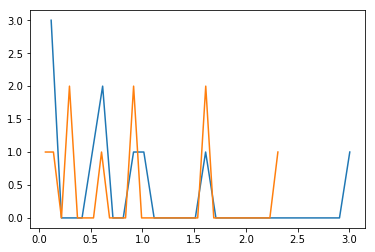

In [6]:
D=1
rm=0.005
gamma=0.577

def tautheory(c,R): 
    phi=math.pi*R*R*c
    gamma=0.577
    kss=2*math.pi*D/(0.5*math.log(2)-gamma-0.5*math.log(phi)) #Eq 4.14 in Szabo1989
    return 1./(c*kss)

def tautheory2(c,kaf,R): 
    ka = kaf*D
    kap=ka/(2*math.pi*D)
    phi=math.pi*R*R*c
    print('phi2^0.5',sqrt(phi*2),'phi',phi)
    gamma=0.577
    kss=2*math.pi*D/(1./kap-gamma+0.5*math.log(2)-0.5*math.log(phi))
    return 1./(c*kss)

def err(a,b):
    return (a-b)*100/a

dist = []
for _ in range(2):
    RXT=np.array(rxt[_])
    hist,bined = np.histogram(RXT,bins=30)
    bn = (bined[:-1]+bined[1:])*0.5
    print('len',len(bn))
    print('ka/2piD',kaf/2/pi)
    #hist = np.log(hist)
    plt.plot(bn,hist)
    C=np.array(conc[_])
    print(C)
    mrxt = np.mean(RXT)
    srxt = np.std(RXT)
    print('mean sim rxntime {:.5f} '.format(mrxt))
    tauT = tautheory2(C,kaf,2*rm)
    dist.append([bn,hist])
    print('theory {:.4f}, sim {:.4f}, error {:.4f}'.format(tauT,mrxt,err(tauT,mrxt)))
print('what dist?')

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

# this is the function we want to fit to our data
def func(x, a, b):
    'nonlinear function in a and b to fit to data'
    return a*np.exp(-x/b)

def expfit(x,y):
    initial_guess = [1400, 0.12]
    pars, pcov = curve_fit(func, x, y, p0=initial_guess)

    alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

    n = len(y)    # number of data points
    p = len(pars) # number of parameters

    dof = max(0, n - p) # number of degrees of freedom

    # student-t value for the dof and confidence level
    tval = t.ppf(1.0-alpha/2., dof)    
    p= pars[1]
    sigma = np.diag(pcov)[1]**0.5 
    print('mt ={:.5f}:[{:.5f} {:.5f}]'.format(p,p-sigma*tval,p+sigma*tval))
    plt.plot(x,y,'.')
    xfit = np.linspace(0,1)
    yfit = func(xfit, pars[0], pars[1])
    plt.plot(xfit,yfit,'-')
    plt.yscale('log')
    return p,sigma*tval

X=[]
Y=[]
for i,j in dist:
    mt,sig=expfit(i,j)
    X.append(mt)
    Y.append(sig)


In [ ]:
plt.errorbar([1,2],X,Y)

kaf 10


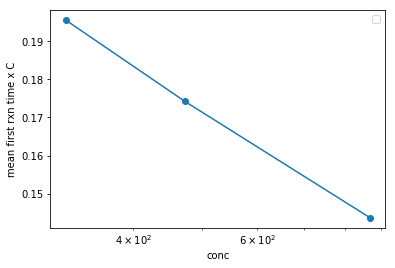

In [5]:
print('kaf',kaf)
rm = 0.005
D = 1
kd= 4.0*math.pi*D

#plt.plot(conc,[1/ka]*len(conc),label='1/ka')
plt.semilogx(conc,rxt*conc,'o-')
plt.xlabel('conc')
plt.ylabel('mean first rxn time x C')
plt.legend()

In [59]:
rm = 0.005
R=2*rm
D = 1
kd= 4.0*math.pi*D
C=np.logspace(0,3.5,30)

Crm=np.array([ 0.86332525   ,1.06600716   ,1.34652569,1.75864373 , 2.39355846,  3.44642192,  5.36112541,  6.99731303,  9.51510999,
 13.68363437, 21.33834073, 84.51656525,129.73533991 ,320.51282051,496.03174603, 868.05555556])
rxtrm=np.array([7.27351210e-01 ,5.97726837e-01 ,4.44661791e-01,0.32699798, 0.22812282, 0.15002535, 0.09155381, 0.06784335, 0.048334,
 0.03031237, 0.01812068, 0.00335746,1.84856909e-03,4.99571073e-04,0.00026003 ,0.00010482])

Crm2=np.array([ 1.74932826 , 2.3787775 ,  3.42090859 , 5.33458518  ,6.96301248 , 9.45251059,
 13.58991085 ,21.12914131 ,80.12820513])
rxtrm2=np.array([0.27137338, 0.19333599, 0.12124948, 0.07248272, 0.05222263, 0.03629452,
 0.02262369, 0.01342985 ,0.00199828])

Crm3=np.array([ 1.75654879  ,9.5345133  ,84.17135247])
rxtrm3=np.array([0.32967616 ,0.04709788 ,0.00336287])

Crm2pp=np.array([ 1.74932826  ,9.45251059 ,80.12820513,124.00793651,320.51282051 ,473.48484848, 868.05555556])
rxtrm2pp=np.array([0.33238285 ,0.04491478 ,0.00328065,0.00199579,0.00061013 ,0.00036796 ,0.00016556])

Crmp1=np.array([ 1.75864373  ,9.51510999 ,84.51656525])
rxnrmp1=np.array([0.46958433 ,0.07518621 ,0.00635457])

Ckf01=np.array([ 1.75654879  ,9.5345133  ,84.17135247,496.03174603 ,868.05555556])
rxnkf01=np.array([0.75266381, 0.12485816 ,0.01204778,0.00186237 ,0.0010119 ])

Ckf012R=np.array([  1.74932826  , 9.45251059,  80.12820513 ,473.48484848, 868.05555556])
rxtkf012R=np.array([0.7643878  ,0.12542833 ,0.0130369  ,0.00187747 ,0.00102033])


Text(0.5,1,'different kf compare with theory')

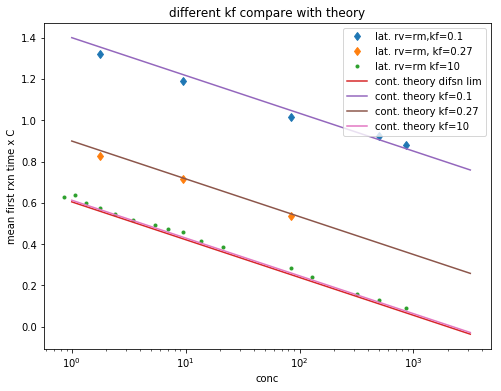

In [52]:


tau=np.array([c*tautheory(c,R) for c in C])
tau2r=np.array([c*tautheory2(c,10,2*R) for c in C])
tau01=np.array([c*tautheory2(c,0.1,R) for c in C])
tau027=np.array([c*tautheory2(c,0.27,R) for c in C])
tau10=np.array([c*tautheory2(c,10,R) for c in C])

plt.subplots(1,1,figsize=(8,6))
#plt.semilogx(Crm2,rxtrm2*Crm2,'x',label='lat. rv=2rm kf=10')
#plt.semilogx(Crm3,rxtrm3*Crm3,'s',label='lat. rv=1.08rm kf=10')
plt.semilogx(Ckf01,rxnkf01*Ckf01,'d',label='lat. rv=rm,kf=0.1')
plt.semilogx(Crmp1,rxnrmp1*Crmp1,'d',label='lat. rv=rm, kf=0.27')
plt.semilogx(Crm,rxtrm*Crm,'.',label='lat. rv=rm kf=10')
plt.semilogx(C,tau,'-',label='cont. theory difsn lim')
plt.semilogx(C,tau01,'-',label='cont. theory kf=0.1')
plt.semilogx(C,tau027,'-',label='cont. theory kf=0.27')
plt.semilogx(C,tau10,'-',label='cont. theory kf=10')

plt.xlabel('conc')
plt.ylabel('mean first rxn time x C')
plt.title('N=100,kfactor={},runs={}'.format(kaf,simrun))
plt.legend()
plt.title('different kf compare with theory')
#plt.savefig("fig2.png",format='png',dpi=900)   

Text(0.5,1,'different voxel size')

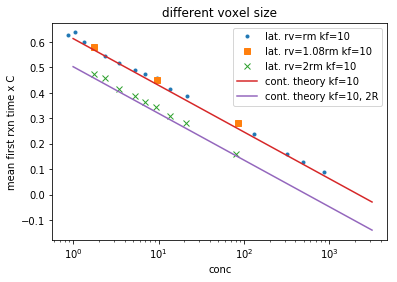

In [39]:
plt.semilogx(Crm,rxtrm*Crm,'.',label='lat. rv=rm kf=10')
plt.semilogx(Crm3,rxtrm3*Crm3,'s',label='lat. rv=1.08rm kf=10')
plt.semilogx(Crm2,rxtrm2*Crm2,'x',label='lat. rv=2rm kf=10')

plt.semilogx(C,tau10,'-',label='cont. theory kf=10')
plt.semilogx(C,tau2r,'-',label='cont. theory kf=10, 2R')
plt.xlabel('conc')
plt.ylabel('mean first rxn time x C')
plt.title('N=100,kfactor={},runs={}'.format(kaf,simrun))
plt.legend()
plt.title('different voxel size')

critical occupancy in lattice 0.04


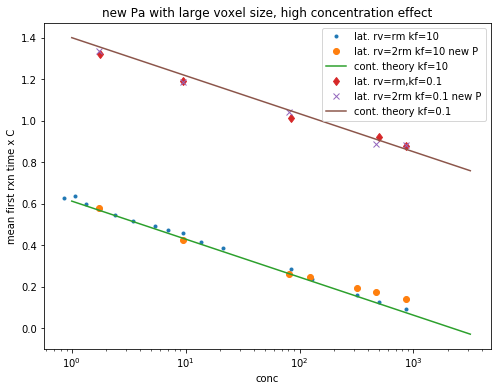

In [61]:
plt.subplots(1,1,figsize=(8,6))
plt.semilogx(Crm,rxtrm*Crm,'.',label='lat. rv=rm kf=10')
plt.semilogx(Crm2pp,rxtrm2pp*Crm2pp,'o',label='lat. rv=2rm kf=10 new P')
plt.semilogx(C,tau10,'-',label='cont. theory kf=10')
plt.semilogx(Ckf01,rxnkf01*Ckf01,'d',label='lat. rv=rm,kf=0.1')
plt.semilogx(Ckf012R,rxtkf012R*Ckf012R,'x',label='lat. rv=2rm kf=0.1 new P')
plt.semilogx(C,tau01,'-',label='cont. theory kf=0.1')
plt.xlabel('conc')
plt.ylabel('mean first rxn time x C')
plt.title('N=100,kfactor={},runs={}'.format(kaf,simrun))
plt.legend()
plt.title('new Pa with large voxel size, high concentration effect')
cc=100
print('critical occupancy in lattice',4*R**2*cc)
#diffusion-influenced situation influenced by slower diffusion due to crowding.

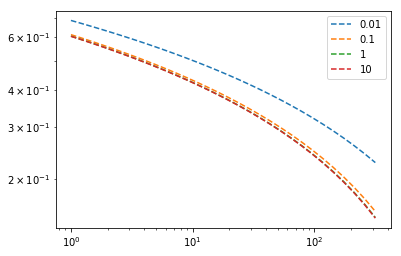

In [56]:
for kf in [0.01,0.1,1,10]:
    tau01=np.array([c*tautheory2(c,kf) for c in C])
    plt.loglog(C,tau01,'--',label=str(kf))
plt.legend()

In [73]:
0.01**2

0.0001

In [91]:
k=0.1
c=1e-6
for y in [0.001,0.01,0.1]:
    phi=1e-4*c
    print('phi,phiy',phi,phi*y)
    print(math.log(phi*y),math.log(phi),math.log(y))
    print(1./(-0.6+1/k+math.log(2)-0.5*math.log(2)-0.5*math.log(phi*y)))

phi,phiy 1e-10 1e-13
-29.933606208922594 -23.025850929940457 -6.907755278982137
0.04046391605453045
phi,phiy 1e-10 1e-12
-27.631021115928547 -23.025850929940457 -4.605170185988091
0.0424410673397292
phi,phiy 1e-10 1.0000000000000001e-11
-25.328436022934504 -23.025850929940457 -2.3025850929940455
0.04462136000238547
